# 第7章 畳み込みニューラルネットワーク

- 第7章は畳み込みニューラルネットワーク(Convolutional Neural Network)のメカニズムについて詳しく説明し、その処理内容を Python で実装する

In [1]:
# %cd /content/drive/MyDrive/work/
# !git clone https://github.com/oreilly-japan/deep-learning-from-scratch.git

In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')
# %cd /content/drive/MyDrive/work/deep-learning-from-scratch/ch04/
# %cd /deep-learning-from-scratch

In [3]:
import numpy as np
import logging
import sys
import os
from pathlib import Path

# importディレクトリの追加
# sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
sys.path.append(os.path.join(Path().resolve(), 'refs'))
print(sys.path)

# プロキシの設定

['/home/jovyan/work/dl_study/01_deep-learning-from-scratch', '/opt/conda/lib/python38.zip', '/opt/conda/lib/python3.8', '/opt/conda/lib/python3.8/lib-dynload', '', '/opt/conda/lib/python3.8/site-packages', '/opt/conda/lib/python3.8/site-packages/IPython/extensions', '/home/jovyan/.ipython', '/home/jovyan/work/dl_study/01_deep-learning-from-scratch/refs']


In [ ]:
import urllib.request
print(urllib.request.getproxies())

In [5]:
import matplotlib as plt
# matplotlibのサイズを大きくする
plt.rcParams['figure.figsize'] = (16.0, 6.0)

## 7.1 全体の構造

- CNNもレゴブロックのようにレイヤを組み合わせることで作る事ができる
- Convolutionレイヤ(畳み込み層)とPoolingレイヤ(プーリング層)が登場する

- これまで見てきたネットワークは隣接する層の全てのニューロン間で結合があった(**全結合**)
    - 全結合層はAffineレイヤという名前で実装されていた
  
- 全結合NNはAffineレイヤの後に活性化関数が続く
- 畳み込みを利用したAffine-Reluというつながりが, Conv-ReLuに置き換わる
    - Poolingレイヤは省略されることがある(多い?)
- 

## 7.2 畳み込み層

### 7.2.1 全結合層の問題点

- 全結合層の問題点はデータの形状が無視されてしまう
    - 画像は3次元形状で空間情報が含まれているが, それが失われる
- CNNは空間情報を維持できる
- 畳み込みそうの入出力データを**特徴マップ**と呼ぶ

### 7.2.2 畳み込み演算

### 7.2.3 パディング

### 7.2.4 ストライド

### 7.2.5 3次元データの畳み込み演算

### 7.2.6 ブロックで考える

### 7.2.7 バッチ処理

## 7.3 プーリング層

### 7.3.1. プーリング層の特徴

## 7.4 Convolution/Poolingレイヤの実装

### 7.4.1 4次元配列

- CNNでは各層を流れるデータは4次元データ
  - PillowやPyTorch(N, C, H, W)
  - OpenCVやCaffeは(N, H, W, C)

### 7.4.2. im2colによる展開

- 畳み込み演算の実装は, 真面目にやると多重forが連なって面倒
    - Numpyでは, **forループを使うと遅い**という弊害もある
- `im2col`を使って実装するとシンプルに実装できる

- im2colは入力データに対してフィルターを適用する場所の領域（3 次元のブロック）を横方向に 1 列に展開する
  - 4次元(N, C, H, W)の入力データに対してim2colを適用すると, 2次元に変換される
  - フィルターの適用領域が重なる場合, **im2colを使って展開すると, 展開後の要素数は元の行列よりも多くなる**という欠点がある


- 大きな行列をまとめて計算すると, コンピュータ計算上は多くの恩恵がある
  - 行列演算ライブラリ(NumpyやEigen等)は行列演算の実装が高度に最適化されていて早い

- im2colによって入力データを展開した後, **フィルターを一列に展開して, 内積を取ればよい**(図7-19)
- 畳み込みの後は, 2次元の出力データを適切な形状に整形(**reshape**)する

![fig7-17_7-18](./images/fig7-17_7-18.PNG)

![fig7-19](./images/fig7-19.PNG)

In [6]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング

    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [7]:
import sys, os
sys.path.append(os.pardir)
from common.util import im2col

x1 = np.random.rand(1, 3, 7, 7)
print(f'x1.shape: {x1.shape}')
print(f'{x1[:3, :3, :3, :3]}')

print('-' * 10)

col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(f'col1.shape: {col1.shape}')

# 2次元目の要素数はフィルタの要素数の総和
print(f'{col1[:3, :3]}') # (9, 75)

print('=' * 25)

x2 = np.random.rand(10, 3, 7, 7) # 10 個のデータ
print(f'x2.shape: {x2.shape}')
# print(f'{x2[:3, :3, :3, :3]}')
# print('-' * 10)
col2 = im2col(x2, 5, 5, stride=1, pad=0)

# バッチサイズNの個数分の要素が返される
print(f'col2.shape: {col2.shape}')      # (90, 75)
# print(f'{col2[:3, :3]}')

x1.shape: (1, 3, 7, 7)
[[[[0.38569167 0.67708352 0.90700092]
   [0.62688193 0.42553286 0.41953192]
   [0.84159003 0.12118447 0.85012963]]

  [[0.92499734 0.22595636 0.84637893]
   [0.03564305 0.98647152 0.42686626]
   [0.38402461 0.51195296 0.8859837 ]]

  [[0.22919471 0.25390699 0.85379493]
   [0.21621359 0.63548508 0.23565323]
   [0.10256485 0.95309328 0.27830992]]]]
----------
col1.shape: (9, 75)
[[0.38569167 0.67708352 0.90700092]
 [0.67708352 0.90700092 0.72373876]
 [0.90700092 0.72373876 0.47345199]]
x2.shape: (10, 3, 7, 7)
col2.shape: (90, 75)


### 7.4.3. Convolutionレイヤの実装

- 順伝播時の処理
  1. Convolution レイヤの初期化メソッドは、フィルター（重み）とバイアス、ストライドとパディングを引数として受け取る
  2. 入力行列を`im2col`で展開し, フィルタもreshapeで2次元配列にする
  3. 展開した入力行列とフィルタの積(内積)を取り, 出力行列の形状に変形する

- 逆伝播時の処理
  1. 逆伝播された行列を順伝播時の変形と逆の形状にする(?)
  1. 順伝播時のフィルタを変形する
  1. 
  1. `col2im`で行列にする

In [8]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        
        # 7.2.4の式(7.1)を参照 
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (H + 2*self.pad - FW) / self.stride)
        
        # im2colを用いて入力行列を展開
        col = im2col(x, FH, FW, self.stride, self.pad)
        
        # np.reshapeの引数に-1を指定すると, 
        # -1以外の引数に応じて, 変換行列の要素数を自動的に合わせてくれる
        # a = np.random.rand(10, 3, 5, 5)
        # a = a.reshape(10, -1)     
        
        # フィルタを展開(flatten)する
        col_w = self.W.reshape(FN, -1).T
        
        # フィルタと入力行列の積を取り, バイアスを加える
        out = np.dot(col, col_W) + self.b
        
        # 得られた積を整形(reshapeと軸の変更)し, 出力値とする
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        # 逆伝播時のためにx, col, col_Wを保持しておく
        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        # 行列の軸の入れ替える(順伝播時と逆の形式?)
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        # 入力の総和を取る
        self.db = np.sum(dout, axis=0)
        
        # 逆伝播行列と順伝播時の入力の積を取り, 整形して保持しておく
        self.dW = np.dot(self.col.T, dout) 
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        # 順伝播時の重みと逆伝播の積を取り, 逆伝播出力とする
        dcol = np.dot(dout, self.col_W.T)
        
        # Convolution レイヤの逆伝播の際には、im2colの逆の処理を行う
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

### 7.4.4. Poolingレイヤの実装

- Poolingレイヤの実装もim2colを使用する
- プーリングの適用領域はチャンネル方向に独立して展開する

In [9]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=2, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None
        
        
    def forward(self, x):
        
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # 展開(1)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        # チャンネル成分ごとにまとめる
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        # 最大化(2)
        out = np.max(col, axis=1)
        
        # 整形(3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        self.x = x
        self.arg_max = arg_max        
        
        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

### 7.5 CNNの実装

- 今までの集大成
- 以下のネットワークを`SimpleConvNet`というクラスに実装する

![fig7-23](./images/fig7-23.PNG)

- 各畳み込み層のハイパラは引数`conv_param`にディクショナリとして与える
- ネットワークの初期化は`__init__`メソッドで行う
    - `conv_param`によって与えられた畳み込み層のハイパラは, ここでパースされる
    - 学習に必要なパラメータは1層目の畳み込みと 2, 3層目の全結合層の重み

In [10]:
import common.layers

class SimpleConvNet:
    
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num': 30, 'filter_size': 5, 'pad':0, 'stride': 1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        '''
        畳み込みを用いた3層NNを初期化する    
        
        Parameters
        ----------
            input_dim: 入力データの次元(C, H, W)
            conv_param: 畳み込み層のハイパラ(dictで渡される)
                - filter_num: フィルタ数
                - filter_size: フィルタサイズ
                - stride: ストライド
                - pad: パディング
            hidden_size: 隠れ層のニューロン数
            output_size: 出力層のニューロン数
            weight_init_std: 重みの初期化に用いる標準偏差
        '''
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        
        input_size = input_dim[1]
        
        # T.B.W
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        # T.B.W
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(filter_num)
        
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)        
        
        self.layers = OrderedDict()
        
        # 学習するレイヤ(畳み込み層)
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        
        # 学習するレイヤ(全結合層 No.1)
        self.layers['Affine1'] = Affine(self.params['W2'],self.params['b2'])
        self.layers['Relu2'] = Relu()
        
        # 学習するレイヤ(全結合層 No.2)
        self.layers['Affine2'] = Affine(self.params['W3'],self.params['b3'])
        
        self.last_layer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward()
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def gradient(self, x, t):
        """
        
        """
        
        # forward
        self.loss(x, t)
        
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        # 設定
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db
        
        return grads

it[0] train loss: 2.299622313622385
=== epoch:1, train acc:0.184, test acc:0.194 ===
it[100] train loss: 0.24273719834964427
it[200] train loss: 0.2750785824111418
it[300] train loss: 0.2573756022771848
it[400] train loss: 0.1468640310685414
it[500] train loss: 0.23591213976483325
it[600] train loss: 0.16750633722574937
=== epoch:2, train acc:0.96, test acc:0.96 ===
it[700] train loss: 0.1892192493888983
it[800] train loss: 0.076840150945274
it[900] train loss: 0.03435584659476596
it[1000] train loss: 0.06967961643955363
it[1100] train loss: 0.03307129597278511
it[1200] train loss: 0.103066887392162
=== epoch:3, train acc:0.979, test acc:0.971 ===
it[1300] train loss: 0.019881971827650925
it[1400] train loss: 0.05971779287445296
it[1500] train loss: 0.028626978069491427
it[1600] train loss: 0.062489463560150955
it[1700] train loss: 0.07698642444183873
it[1800] train loss: 0.060708980617517054
=== epoch:4, train acc:0.982, test acc:0.981 ===
it[1900] train loss: 0.01800483405791722
it[2

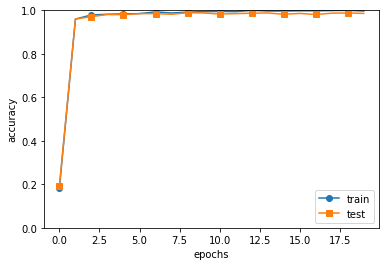

CPU times: user 1h 39s, sys: 2h 2min 13s, total: 3h 2min 53s
Wall time: 30min 48s


In [11]:
%%time
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from ch07.simple_convnet import SimpleConvNet
from common.trainer import Trainer

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
# x_train, t_train = x_train[:5000], t_train[:5000]
# x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000, verbose=False)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


## 7.6 CNNの可視化

- CNNで用いられる畳み込み層のフィルター(重み)を画像として表示する
- 畳み込み層のフィルターは、エッジやブロブなどのプリミティブな情報を抽出する

# 7.6.1 1層目の重みの可視化

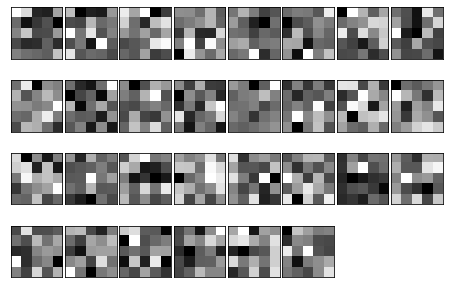

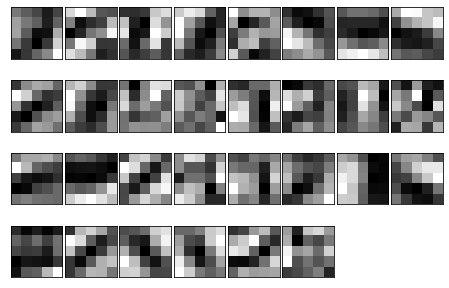

In [12]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from ch07.simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("params.pkl")
filter_show(network.params['W1'])

- 学習前のフィルタはランダムに初期化されているので, 規則性が見られない
- 学習を終えたフィルタは気息性がある画像になっている
- 畳み込み層のフィルタは`エッジ`や`blob`を見ている 

## 7.6.2 階層構造による情報抽出

- DNNの可視化に関する研究によると層が深くなるにしたがって, 抽出される情報は抽象化されていく
 - [Visualizing and Understanding Convolutional Networks]()
 - [Understanding Deep Image Representations by Inverting Them](https://arxiv.org/abs/1412.0035)